In [99]:
import sqlite3
from sqlite3 import Error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dateutil import parser
import numpy as np

conn1 = None
conn2 = None
try:
    conn1 = sqlite3.connect("elprotest2_carmine.db")
    conn2 = sqlite3.connect("elprotest.db")
    print(sqlite3.version)
except Error as e:
    print(e)

2.6.0


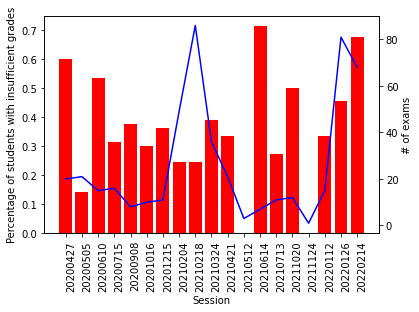

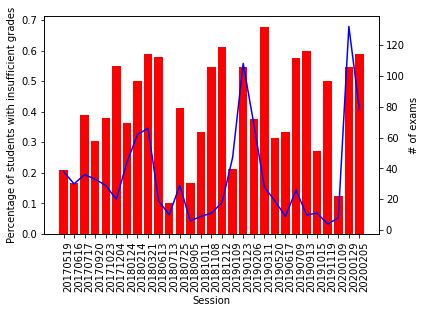

In [100]:
def perc_insuf(connection):
    cur = connection.cursor()
    cur.execute('select session,  count(student) from results where grade ="INSUF" group by session order by session asc')
    rows = cur.fetchall()
    insuff = {}
    for row in rows:
       insuff[row[0]]= row[1]
    # print(insuff)

    cur.execute('select session,  count(student) from results where grade !="ASS" group by session order by session asc')
    rows = cur.fetchall()
    exams = {}
    for row in rows:
        exams[row[0]]= row[1]
    # print(exams)
    insuff_perc = {}
    for key in exams.keys():
        if key not in insuff.keys():
            insuff_perc[key] = 0
        else:
            insuff_perc[key] = insuff[key]/exams[key]

    # print(insuff_perc)

    fig, ax1 = plt.subplots()
    # plot vertical bars
    ax1.bar(insuff_perc.keys(), insuff_perc.values(), color='r')
    ax1.set_xlabel('Session')
    ax1.set_ylabel('Percentage of students with insufficient grades')
    # plot lines exams on second axis
    ax2 = ax1.twinx()
    ax2.plot(exams.keys(), exams.values(), color='b')
    ax2.set_ylabel('# of exams')
    # rotate x labels of ax1
    plt.setp(ax1.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
    plt.show()

perc_insuf(conn1)
perc_insuf(conn2)

# Evalute the performance
We want to compare how many students compile, execute, generate the outfile and pass the test
- Global percentage and per session
- We want also to see the level of plagiarism (max min and deviation). Maybe boxplot?


{'OTT': 0.0, 'DIT': 9.433962264150944, 'BUO': 3.7735849056603774, 'DIS': 0.0, 'SUF': 15.09433962264151, 'INSUF': 71.69811320754717, 'RIT': 0.0}
{'OTT': 20.79646017699115, 'DIT': 20.353982300884955, 'BUO': 9.734513274336283, 'DIS': 5.752212389380531, 'SUF': 12.831858407079647, 'INSUF': 30.088495575221238, 'RIT': 0.4424778761061947}


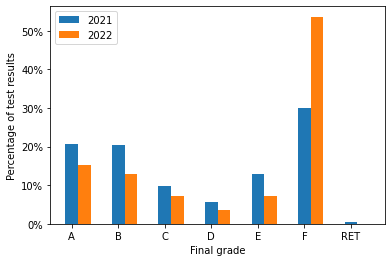

In [101]:
cur = conn1.cursor()
cur.execute('SELECT results.grade, count(*) '
            'FROM results, grade_sort '
            'where results."session" like "2020%" and grade_sort.grade = results.grade '
            'and results.grade!="ASS" and results.grade!="IDO"   group by results.grade order by grade_sort.id')


rows = cur.fetchall()

labels = ['OTT','DIT', 'BUO', 'DIS', 'SUF', 'INSUF', 'RIT']
values2020 = {'OTT':0,'DIT':0, 'BUO':0, 'DIS':0, 'SUF':0, 'INSUF':0, 'RIT':0}
sum_2020 = 0
for row in rows:
       values2020[row[0]]=row[1]
       sum_2020 += row[1]

cur.execute('SELECT results.grade, count(*) '
            'FROM results, grade_sort '
            'where results."session" like "2021%" and grade_sort.grade = results.grade '
            'and results.grade!="ASS" and results.grade!="IDO"  group by results.grade order by grade_sort.id')
rows = cur.fetchall()

values2021 = {'OTT':0,'DIT':0, 'BUO':0, 'DIS':0, 'SUF':0, 'INSUF':0, 'RIT':0}
sum_2021 = 0
for row in rows:
       values2021[row[0]]= row[1]
       sum_2021 += row[1]

cur.execute('SELECT results.grade, count(*) '
            'FROM results, grade_sort '
            'where results."session" like "2022%" and grade_sort.grade = results.grade '
            'and results.grade!="ASS" and results.grade!="IDO"   group by results.grade order by grade_sort.id')
rows = cur.fetchall()

values2022 = {'OTT':0,'DIT':0, 'BUO':0, 'DIS':0, 'SUF':0, 'INSUF':0, 'RIT':0}
sum_2022 = 0
for row in rows:
       values2022[row[0]]= row[1]
       sum_2022 += row[1]



for key in labels:
    values2020[key] = 100*values2020[key]/sum_2020
    values2021[key] = 100*values2021[key]/sum_2021
    values2022[key] = 100*values2022[key]/sum_2022

print(values2020)
print(values2021)

ind = np.arange(7)
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.bar(ind, values2020.values(),0.27, label="2020")
ax.bar(ind+0.27, values2021.values(),0.27, label="2021")
ax.bar(ind+0.54, values2022.values(),0.27, label="2022")
ax.legend()
# plt.xticks(rotation=90)
ax.set_xticks(ind+0.27)
ax.set_xticklabels(['A', 'B', 'C', 'D', 'E', 'F', 'RET'])
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
import matplotlib.ticker as mtick
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)

plt.ylabel("Percentage of test results")
plt.xlabel("Final grade")
plt.savefig("images/grade_percent.png",dpi=300, bbox_inches = "tight")
plt.show()


In [102]:
import os
import json
# Check build/exec/outfile
data_path = "data/postcovid"
dir_list = os.listdir(data_path)
for dir in dir_list:
    filename = os.path.join(data_path, dir+"/submissions.js")
    if not os.path.isfile(filename) :
        print(filename)
    else:
        with open(filename) as f:
            str_line = f.readline()
            str_line = str_line[16:-2]
            str_line = str_line.replace('id:', '"id":')
            str_line = str_line.replace('data:', '"data":')
            # str_line = str_line.replace('""', '"0"')
            str_line = str_line.replace(',]', ']')
            json_obj = json.loads(str_line)
            submissions_file = os.path.join(data_path, dir+"/submissions.csv")
            csv_file = open(submissions_file, "w")
            for row in json_obj:
                values = row['data']
                # remove item from values
                values.pop(1)
                values.pop(6)
                plagiarism = values.pop(7)
                values.pop(7)
                plag_value = plagiarism.split('<')[1].split('>')[1]
                values.append(plag_value[:-1])
                # write values in csv file
                csv_file.write(",".join(values)+"\n")
            csv_file.close()

data/postcovid/20220112/submissions.js
data/postcovid/20211020/submissions.js
data/postcovid/20200427/submissions.js
data/postcovid/tests.csv/submissions.js


In [103]:
# Merge csv files
import pandas as pd
fout = open("data/postcovid/tests.csv", "w")
head = True
for dir in dir_list:
    filename = os.path.join(data_path, dir+"/submissions.csv")
    if not os.path.isfile(filename) :
        print(filename)
    else:
        with open(filename) as f:
            df  = pd.read_csv(filename, names=["id", "upload", "build", "exec","outfile", "test", "exercise", "plagiarism"])
            df['session'] = os.path.basename(dir)
            # print(df.head())
            df.to_csv(fout, index=False, header=head)
            head = False
fout.close()

data/postcovid/20220112/submissions.csv
data/postcovid/20211020/submissions.csv
data/postcovid/20200427/submissions.csv
data/postcovid/tests.csv/submissions.csv


test
0    309
1     38
2     19
3     48
Name: id, dtype: int64
414 309


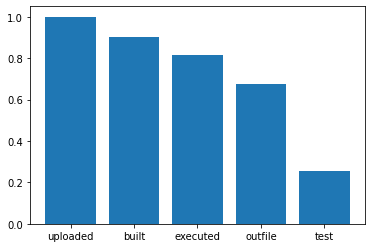

In [104]:

import pandas as pd
df = pd.read_csv("data/postcovid/tests.csv")
df['plagiarism'] = df['plagiarism'].astype(float)
df['plagiarism'] = df['plagiarism'].round(2)

# sum the column of df['plagiarism']
values = []
values.append(df['upload'].sum())
values.append(df['build'].sum())
values.append(df['exec'].sum())
values.append(df['outfile'].sum())
# count if the items is not 0
test_score = df.groupby(df["test"]).count()["id"]
print(test_score)
print(test_score.sum(), test_score.iloc[0])

values.append(test_score.sum()-test_score.iloc[0])

plt.bar(['uploaded', 'built', 'executed', 'outfile', 'test'], values/test_score.sum())
plt.show()

la differenza tra la percentuale di compiti che eseguono e quelli che superano il test da una informazione anche sulla difficoltà della traccia


<BarContainer object of 19 artists>

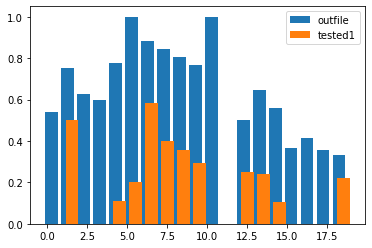

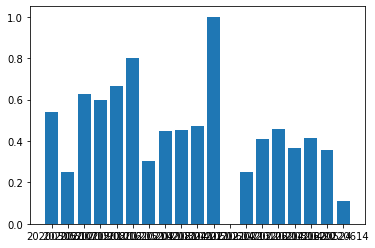

In [105]:
# set the tested to 1 when teted is not 0
df = df[df["upload"]==1]
df["tested1"] = df["test"] != 0
res_result = df.groupby(df["session"]).sum()["upload"]
# sort res_results by index
res_result = res_result.sort_index()
res_built= df.groupby(df["session"]).sum()["build"]
res_built = res_built.sort_index()
res_exec = df.groupby(df["session"]).sum()["exec"]
res_exec = res_exec.sort_index()
res_outfile = df.groupby(df["session"]).sum()["outfile"]
res_outfile = res_outfile.sort_index()
res_test = df.groupby(df["session"]).sum()["tested1"]
res_concat = pd.concat([res_result, res_built,res_exec,res_outfile, res_test], axis=1)

# divide all the elements of the row by the sum of the row
res_concat = res_concat.div(res_concat["upload"], axis=0)


# print(res_concat)
labels = res_concat.index.tolist()
for i in range(len(labels)):
    labels[i] = str(labels[i])
ind = np.arange(len(labels))

plt.bar(ind+0.27, res_concat["outfile"], label="outfile")
plt.bar(ind+0.54, res_concat["tested1"], label="tested1")
print("la differenza tra la percentuale di compiti che eseguono e quelli che superano il test da una informazione anche sulla difficoltà della traccia")
plt.legend()
plt.figure()
plt.bar(labels, res_concat["outfile"]-res_concat["tested1"])

plag>0 191 414
plag (191, 2)
count    191.000000
mean      39.440471
std       31.067376
min        6.150000
25%       14.150000
50%       26.540000
75%       63.700000
max      100.000000
Name: plagiarism, dtype: float64


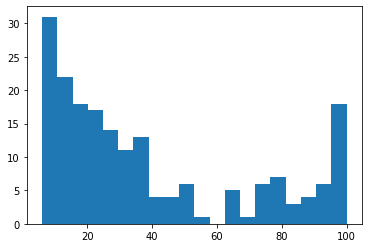

      session  plagiarism
13   20220524       50.62
14   20220524       50.62
15   20220524        8.73
18   20220524       24.62
21   20220524       62.98
..        ...         ...
351  20210218      100.00
358  20220420       16.18
359  20220420       16.18
365  20220420       10.57
366  20220420       10.57

[191 rows x 2 columns]


In [126]:
# select only session and  plagiarism columns

df_plag = df[["session", "plagiarism"]]
#count plagiarism if plagiarism is not 0
temp = df_plag["plagiarism"].apply(lambda x: 1 if x != 0 else 0)
print("plag>0", temp.sum(), temp.count())
df_plag = df_plag[df_plag["plagiarism"] != 0]
print("plag", df_plag.shape)
print(df_plag['plagiarism'].describe())
# count the number of sessions with plagiarism
plt.hist(df_plag['plagiarism'], bins=20)
plt.show()
print(df_plag)

In [130]:
# print(df_plag)
df_plag = df_plag[df_plag["plagiarism"] > 70]
print("plag", df_plag.shape)
print(len(df_plag)/len(df))



plag (45, 2)
0.10869565217391304
